![UCI](http://mlr.cs.umass.edu/ml/assets/logo.gif)

# Loading in the Data
In this example, we are going to use crossed columns and embedding columns inside of a tensorflow object created with the contrib "learn" library.

However, we will start the process by loading up a dataset with a mix of categorical data and numeric data. This dataset is quite old and has been used many times in machine learning examples: the census data from 1990's. We will use it to predict if a person will earn over or under 50k per year.

- https://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD)

In [12]:
import pandas as pd

headers = ['age','workclass','fnlwgt','education','edu_num','marital_status',
           'occupation','relationship','race','sex','cap_gain','cap_loss','work_hrs_weekly','country','income']
df_train_orig = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',names=headers)
df_test_orig = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',names=headers)
df_test_orig = df_test_orig.iloc[1:]
print(df_train_orig.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age                32561 non-null int64
workclass          32561 non-null object
fnlwgt             32561 non-null int64
education          32561 non-null object
edu_num            32561 non-null int64
marital_status     32561 non-null object
occupation         32561 non-null object
relationship       32561 non-null object
race               32561 non-null object
sex                32561 non-null object
cap_gain           32561 non-null int64
cap_loss           32561 non-null int64
work_hrs_weekly    32561 non-null int64
country            32561 non-null object
income             32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None


In [13]:
from copy import deepcopy
df_train = deepcopy(df_train_orig)
df_test = deepcopy(df_test_orig)

The data is organized as follows: 

|Variable | description|
|----|--------|
|age: | continuous|
|workclass:      |Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, ...|
|fnlwgt:         |continuous.|
|education:      |Bachelors, Some-college, 11th, HS-grad, Prof-school, ...|
|education-num:  |continuous.|
|marital-status: |Married-civ-spouse, Divorced, Never-married, Separated, Widowed, ... |
|occupation:     |Tech-support, Craft-repair, Other-service, ...|
|relationship:   | Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.|
|race:           |White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.|
|sex:            |Female, Male.|
|capital-gain:   |continuous.|
|capital-loss:   |continuous.|
|hours-per-week: |continuous.|
|native-country: |United-States, Cambodia, England, ... |

In [14]:

import numpy as np

# let's just get rid of rows with any missing data
# and then reset the indices of the dataframe so it corresponds to row number
df_train.replace(to_replace=' ?',value=np.nan, inplace=True)
df_train.dropna(inplace=True)
df_train.reset_index()

df_test.replace(to_replace=' ?',value=np.nan, inplace=True)
df_test.dropna(inplace=True)
df_test.reset_index()

df_test.head()

,age,workclass,fnlwgt,education,edu_num,marital_status,occupation,relationship,race,sex,cap_gain,cap_loss,work_hrs_weekly,country,income
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
6,34,Private,198693.0,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States,<=50K.


## Processing
For preprocessing, we are going to fix a few issues in the dataset. 

- This first includes the use of "50K." instead of "50K" in the test set. 
- Next, we will encode the categorical features as integers (later on we will encode one hot)
- Finally, we will make certain all the continuous data is scaled properly

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

if df_test.income.dtype=='object':
    df_test.income.replace(to_replace=[' <=50K.',' >50K.'],value=['<=50K','>50K'],inplace=True)
    print(df_test.income.value_counts())

encoders = dict() 
categorical_headers = ['workclass','education','marital_status',
                       'occupation','relationship','race','sex','country']

for col in categorical_headers+['income']:
    df_train[col] = df_train[col].str.strip()
    df_test[col] = df_test[col].str.strip()
    
    if col=="income":
        tmp = LabelEncoder()
        df_train[col] = tmp.fit_transform(df_train[col])
        df_test[col] = tmp.transform(df_test[col])
    else:
        encoders[col] = LabelEncoder()
        df_train[col+'_int'] = encoders[col].fit_transform(df_train[col])
        df_test[col+'_int'] = encoders[col].transform(df_test[col])


numeric_headers = ["age", "edu_num", "cap_gain", "cap_loss","work_hrs_weekly"]

for col in numeric_headers:
    df_train[col] = df_train[col].astype(np.float)
    df_test[col] = df_test[col].astype(np.float)
    
    ss = StandardScaler()
    df_train[col] = ss.fit_transform(df_train[col].values.reshape(-1, 1))
    df_test[col] = ss.transform(df_test[col].values.reshape(-1, 1))
    
df_test.head()

<=50K    11360
>50K      3700
Name: income, dtype: int64


,age,workclass,fnlwgt,education,edu_num,marital_status,occupation,relationship,race,sex,...,country,income,workclass_int,education_int,marital_status_int,occupation_int,relationship_int,race_int,sex_int,country_int
1,-1.023104,Private,226802.0,11th,-1.224066,Never-married,Machine-op-inspct,Own-child,Black,Male,...,United-States,0,2,1,4,6,3,2,1,38
2,-0.033340,Private,89814.0,HS-grad,-0.439738,Married-civ-spouse,Farming-fishing,Husband,White,Male,...,United-States,0,2,11,2,4,0,4,1,38
3,-0.794697,Local-gov,336951.0,Assoc-acdm,0.736754,Married-civ-spouse,Protective-serv,Husband,White,Male,...,United-States,1,1,7,2,10,0,4,1,38
4,0.423474,Private,160323.0,Some-college,-0.047574,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,...,United-States,1,2,15,2,6,0,2,1,38
6,-0.337883,Private,198693.0,10th,-1.616231,Never-married,Other-service,Not-in-family,White,Male,...,United-States,0,2,0,4,7,1,4,1,38


In [16]:
# let's start as simply as possible, without any feature preprocessing
categorical_headers_ints = [x+'_int' for x in categorical_headers]

# we will forego one-hot encoding right now and instead just scale all inputs
feature_columns = categorical_headers_ints+numeric_headers
X_train =  ss.fit_transform(df_train[feature_columns].values).astype(np.float32)
X_test =  ss.transform(df_test[feature_columns].values).astype(np.float32)

y_train = df_train['income'].values.astype(np.int)
y_test = df_test['income'].values.astype(np.int)

print(feature_columns)

['workclass_int', 'education_int', 'marital_status_int', 'occupation_int', 'relationship_int', 'race_int', 'sex_int', 'country_int', 'age', 'edu_num', 'cap_gain', 'cap_loss', 'work_hrs_weekly']


![keras](https://blog.keras.io/img/keras-tensorflow-logo.jpg)


# An example similar to Sklearn, Keras
We will start with creating a model that is similar to what we have seen in scikit-learn. Let's not worry about pre-processing the data right now. Let's just get familiar with Keras.

In [17]:
from sklearn import metrics as mt

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.layers import Embedding, Flatten, Merge, concatenate
from keras.models import Model

In [19]:
# combine the features into a single large matrix
X_train = df_train[feature_columns].values
X_test = df_test[feature_columns].values

# This returns a tensor
inputs = Input(shape=(X_train.shape[1],))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(units=10, activation='relu')(inputs)
predictions = Dense(1,activation='sigmoid')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)

___
## Adding more customization
For this particular optimization, let's go beyond SGD and use a different optimizer. There are many excellent explanations of different optimizers, for instance:
- http://sebastianruder.com/optimizing-gradient-descent/

Now that we have defined the model, its as simple as using it in a very familiar syntax:

In [20]:
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 13)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                140       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 151.0
Trainable params: 151.0
Non-trainable params: 0.0
_________________________________________________________________


In [21]:
%%time

model.fit(X_train, y_train, epochs=10, batch_size=50, verbose=0)

from sklearn import metrics as mt
yhat = np.round(model.predict(X_test))
print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

[[10122  1238]
 [ 1579  2121]] 0.812948207171
CPU times: user 8.67 s, sys: 3.19 s, total: 11.9 s
Wall time: 8.09 s


Now let's only use the sparse data to build the same model, but now the model will accept scipy sparse arrays!

# Handle Data that Should be not be Numeric...

In [22]:
# but we were dealing with the data incorrectly because we didn't one hot encode the 
#   categorical features
from sklearn.preprocessing import OneHotEncoder

# now let's encode the integer outputs as one hot encoded labels
ohe = OneHotEncoder()
X_train_ohe = ohe.fit_transform(df_train[categorical_headers_ints].values)
X_test_ohe = ohe.transform(df_test[categorical_headers_ints].values)

# the ohe instance will help us to organize our encoded matrix
print(ohe.feature_indices_)
print(X_train_ohe.shape)
print(type(X_train_ohe), '========THIS IS SPARSE ENCODED=======')

[ 0  7 23 30 44 50 55 57 98]
(30162, 98)
<class 'scipy.sparse.csr.csr_matrix'> ========THIS IS SPARSE ENCODED=======


In [23]:
# This returns a tensor
inputs = Input(shape=(X_train_ohe.shape[1],),sparse=True)

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(units=10, activation='relu')(inputs)
predictions = Dense(1,activation='sigmoid')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit(X_train_ohe,y_train, epochs=10, batch_size=50, verbose=0)

# test on the data
yhat = np.round(model.predict(X_test_ohe))
print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

[[10573   787]
 [ 1852  1848]] 0.824767596282


# Combine separate branches, Sparse and Dense

In [24]:
# combine the features with two branches

# let's encode the integer outputs as one hot encoded labels
ohe = OneHotEncoder()
X_train_ohe = ohe.fit_transform(df_train[categorical_headers_ints].values)
X_test_ohe = ohe.transform(df_test[categorical_headers_ints].values)

# and save off the numeric features
X_train_num =  df_train[numeric_headers].values
X_test_num = df_test[numeric_headers].values

# create sparse input branch for ohe
inputsSparse = Input(shape=(X_train_ohe.shape[1],),sparse=True)
xSparse = Dense(units=10, activation='relu')(inputsSparse)

# create dense input branch for numeric
inputsDense = Input(shape=(X_train_num.shape[1],),sparse=False)
xDense = Dense(units=10, activation='relu')(inputsDense)

x = concatenate([xSparse, xDense])
predictions = Dense(1,activation='sigmoid')(x)

# This creates a model that includes
# the Input layer and Dense layers
model = Model(inputs=[inputsSparse,inputsDense], outputs=predictions)

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 98)            0                                            
____________________________________________________________________________________________________
input_5 (InputLayer)             (None, 5)             0                                            
____________________________________________________________________________________________________
dense_7 (Dense)                  (None, 10)            990                                          
____________________________________________________________________________________________________
dense_8 (Dense)                  (None, 10)            60                                           
___________________________________________________________________________________________

In [25]:
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit([X_train_ohe,X_train_num],y_train, epochs=10, batch_size=50, verbose=0)

yhat = np.round(model.predict([X_test_ohe,X_test_num]))
print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

[[10684   676]
 [ 1777  1923]] 0.837118193891


So the confusion matrix is doing pretty well! But we still are just using an MLP with one hidden layer. We really want to take advantage of the embeddings and crossed columns that are possible with tensorflow. 


# [Back to Slides]
___

# Crossed Columns and Deep Embeddings
Lets create the network below in pieces:
![asdfasfd](https://www.tensorflow.org/images/wide_n_deep.svg)

## Step One: Using Dense embeddings 
First let's try a deeper architecture with dense embeddings for the categorical features, as described in lecture.

- the size of the dense feature embeddings. This can be difficult to set, but one common setting is $log_2(N)$ where $N$ is the total number of uniques values.

In [26]:
# we need to create separate sequential models for each embedding
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_branch_outputs = []

for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( df_train[col].values )
    X_ints_test.append( df_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32')
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x)

# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_num.shape[1],),sparse=False))
x = Dense(units=20, activation='relu')(all_inputs[-1])
all_branch_outputs.append( Dense(units=10,activation='relu')(x) )

# merge the branches together
final_branch = concatenate(all_branch_outputs)
final_branch = Dense(units=1,activation='sigmoid')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit(X_ints_train + [X_train_num],
        y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
30162/30162 [==============================] - 4s - loss: 0.1835 - acc: 0.7456       

In [27]:
yhat = np.round(model.predict(X_ints_test + [X_test_num]))
print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

[[10629   731]
 [ 1718  1982]] 0.837383798141


That works fairly well using the embeddings. Now let's try to perform the same thing with embeddings.


___


## Step Two: Adding Crossed Columns
For this example, we are going to combine our `learn` syntax with the syntax we have just gone over. 

Let's start simple with just a linear classifier that takes the categorical features as input and makes one set of crossed columns.

In [28]:
cross_columns = [['education','occupation'],
                 ['country', 'occupation']]

# we need to create separate sequential models for each embedding
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_branch_outputs = []

for cols in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)
    
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32')
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x)
    
# merge the branches together
final_branch = concatenate(all_branch_outputs)
final_branch = Dense(units=1,activation='sigmoid')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit(X_ints_train,
        y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
30162/30162 [==============================] - 2s - loss: 0.2075 - acc: 0.7443       

In [29]:
yhat = np.round(model.predict(X_ints_test))
print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

[[10998   362]
 [ 3198   502]] 0.763612217795


Wow! That is just using crossed columns and a one layer Linear Classifer! So memorization works fairly well here.


___


## Step 3 (Final): Combining Crossed Linear Classifier and Deep Embeddings
Now its just a matter of setting the wide and deep columns for tensorflow. After which, we can use the combined classifier!

Wide and deep models can have really interesting and useful properties so they are great to keep in mind when selecting an architecture. Some of the hyperparameters that are specific to this are:
- which features to cross together, typically you only want to cross columns you think are important to be connected--they somehow might create new knowledge by combining.
- the size of the dense feature embeddings. This can be difficult to set, but one common setting is $log_2(N)$ where $N$ is the total number of uniques values.

In [36]:
cross_columns = [['education','occupation'],
                 ['country', 'occupation'],
                 ['relationship','marital_status','sex']]

#'workclass','education','marital_status','occupation','relationship','race','sex','country'

# we need to create separate sequential models for each embedding
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_branch_outputs = []

for cols in cross_columns:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)
    
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32',name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x)
    
# merge the branches together
wide_branch = concatenate(all_branch_outputs)

# reset this input branch
all_branch_outputs = []
# add in the embeddings
for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( df_train[col].values )
    X_ints_test.append( df_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x)
    
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_num.shape[1],),sparse=False,name='numeric_data'))
x = Dense(units=20, activation='relu')(all_inputs[-1])
all_branch_outputs.append( x )

# merge the branches together
deep_branch = concatenate(all_branch_outputs)
deep_branch = Dense(units=50,activation='sigmoid')(deep_branch)
deep_branch = Dense(units=10,activation='sigmoid')(deep_branch)
    
final_branch = concatenate([wide_branch, deep_branch])
final_branch = Dense(units=1,activation='sigmoid')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)

model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit(X_ints_train+ [X_train_num],
        y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
30162/30162 [==============================] - 6s - loss: 0.1213 - acc: 0.8287       

In [37]:
yhat = np.round(model.predict(X_ints_test + [X_test_num]))
print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

[[10516   844]
 [ 1407  2293]] 0.850531208499


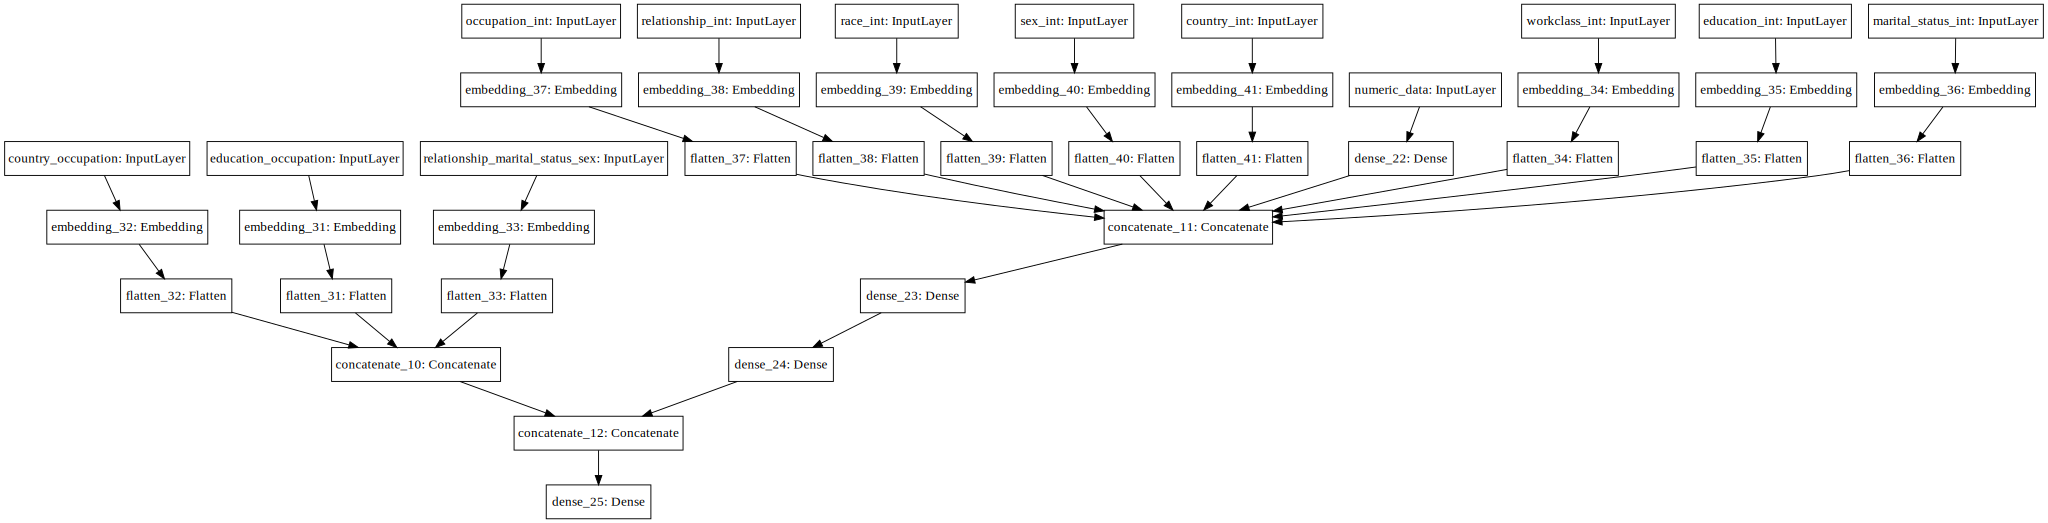

In [38]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))